<a href="https://colab.research.google.com/github/veeravallisarathkumar/Customer-Churn-Prediction-Lloyds-Banking-Group-/blob/main/LLOYDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [15]:
import pandas as pd

# Load the Excel file
file_path = '/content/Customer_Churn_Data_Large.xlsx'
xls = pd.ExcelFile(file_path)

# Read all sheets into DataFrames
demographics = xls.parse('Customer_Demographics')
transactions = xls.parse('Transaction_History')
service = xls.parse('Customer_Service')
online = xls.parse('Online_Activity')
churn = xls.parse('Churn_Status')

# Merge sheets on 'CustomerID' using full outer joins
df = demographics.merge(transactions, on='CustomerID', how='outer')
df = df.merge(service, on='CustomerID', how='outer')
df = df.merge(online, on='CustomerID', how='outer')
df = df.merge(churn, on='CustomerID', how='outer')

# Preview merged data
print("Shape after merging:", df.shape)
print(df.head())

# ----------------------------
# Data Cleaning
# ----------------------------

# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Fill or drop missing values
# Example: Fill missing numeric columns with median
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Convert categorical to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Save cleaned dataset
df.to_csv('/content/Customer_Churn_Data_.csv', index=False)


Shape after merging: (6812, 17)
   CustomerID  Age Gender MaritalStatus IncomeLevel  TransactionID  \
0           1   62      M        Single         Low           7194   
1           2   65      M       Married         Low           7250   
2           2   65      M       Married         Low           9660   
3           2   65      M       Married         Low           2998   
4           2   65      M       Married         Low           1228   

  TransactionDate  AmountSpent ProductCategory  InteractionID InteractionDate  \
0      2022-03-27       416.50     Electronics         6363.0      2022-03-31   
1      2022-08-08        54.96        Clothing         3329.0      2022-03-17   
2      2022-07-25       197.50     Electronics         3329.0      2022-03-17   
3      2022-01-25       101.31       Furniture         3329.0      2022-03-17   
4      2022-07-24       397.37        Clothing         3329.0      2022-03-17   

  InteractionType ResolutionStatus LastLoginDate  LoginFrequ

In [ ]:
df.head()

,CustomerID,Age,TransactionID,TransactionDate,AmountSpent,InteractionID,InteractionDate,LastLoginDate,LoginFrequency,ChurnStatus,...,IncomeLevel_Medium,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,InteractionType_Feedback,InteractionType_Inquiry,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,62,7194,2022-03-27,416.50,6363.0,2022-03-31,2023-10-21,34,0,...,False,False,True,False,False,False,True,False,False,False
1,2,65,7250,2022-08-08,54.96,3329.0,2022-03-17,2023-12-05,5,1,...,False,True,False,False,False,False,True,False,False,True
2,2,65,9660,2022-07-25,197.50,3329.0,2022-03-17,2023-12-05,5,1,...,False,False,True,False,False,False,True,False,False,True
3,2,65,2998,2022-01-25,101.31,3329.0,2022-03-17,2023-12-05,5,1,...,False,False,False,True,False,False,True,False,False,True
4,2,65,1228,2022-07-24,397.37,3329.0,2022-03-17,2023-12-05,5,1,...,False,True,False,False,False,False,True,False,False,True


In [29]:
df.describe()

,CustomerID,Age,TransactionID,AmountSpent,InteractionID,LoginFrequency,ChurnStatus,Gender_M,MaritalStatus_Married,MaritalStatus_Single,...,IncomeLevel_Medium,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,InteractionType_Feedback,InteractionType_Inquiry,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website
count,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,...,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000
mean,496.470407,43.140085,5495.988470,254.354940,5921.861261,25.918332,0.205995,0.450999,0.223866,0.232321,...,0.345888,0.197925,0.206380,0.193121,0.196964,0.369139,0.290930,0.482513,0.367794,0.312068
std,286.681289,15.430343,2595.575295,143.329654,2332.331260,14.110627,0.404466,0.497641,0.416874,0.422353,...,0.475703,0.398473,0.404745,0.394785,0.397743,0.482618,0.454235,0.499742,0.482251,0.463382
min,1.000000,18.000000,1000.000000,5.180000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,244.000000,29.000000,3218.000000,128.940000,3873.250000,14.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,504.000000,43.000000,5490.000000,255.175000,5903.000000,27.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,743.000000,57.000000,7713.000000,378.605000,7851.000000,38.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,995.000000,69.000000,9997.000000,499.700000,9997.000000,49.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


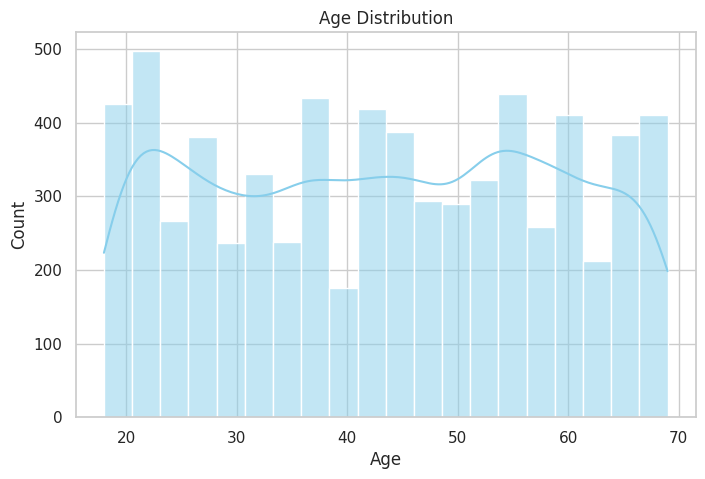

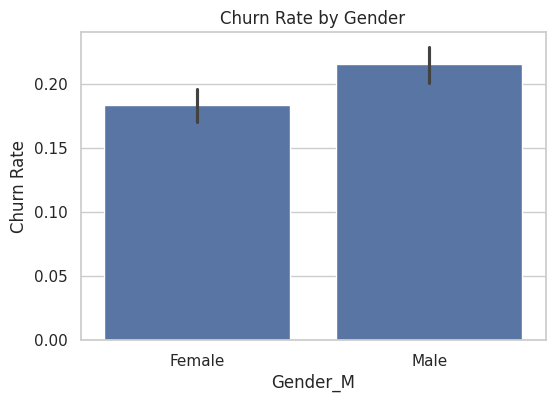

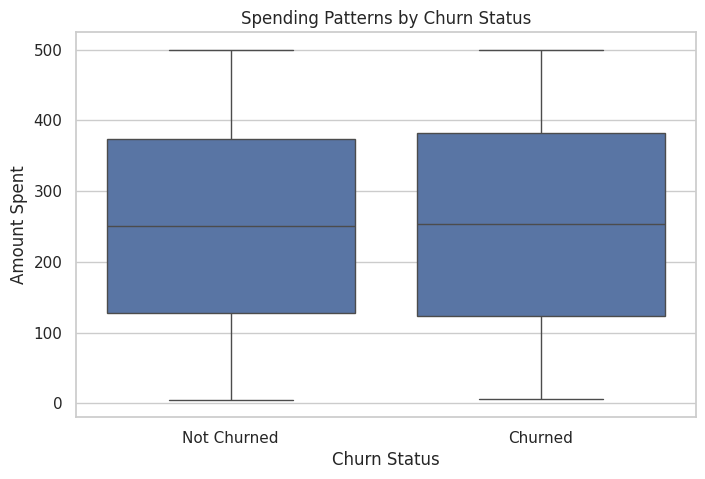

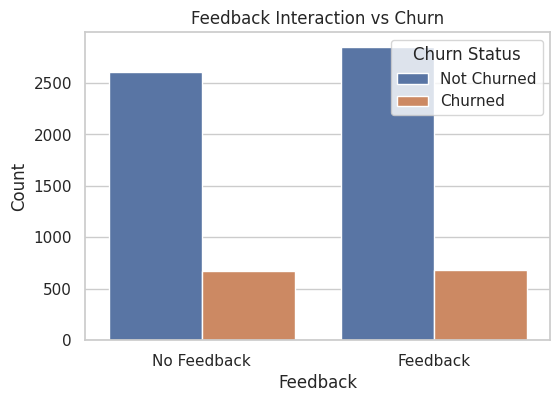

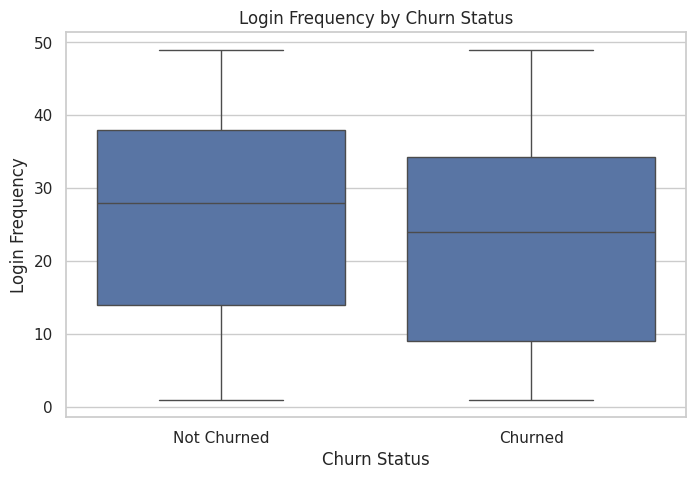

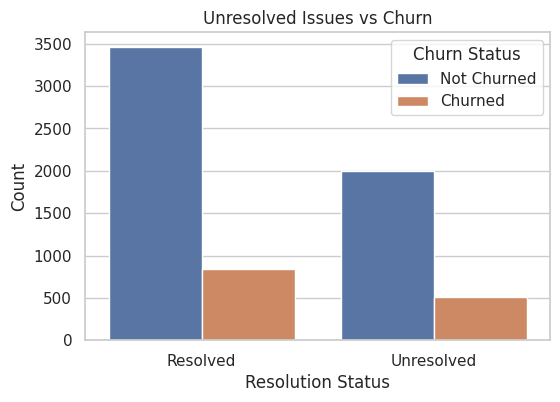

In [18]:
# Set up the visual style
sns.set(style="whitegrid")

# Distribution of Age
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Churn Rate by Gender
plt.figure(figsize=(6, 4))
sns.barplot(x='Gender_M', y='ChurnStatus', data=df)
plt.xticks([0, 1], ['Female', 'Male'])
plt.title("Churn Rate by Gender")
plt.ylabel("Churn Rate")
plt.show()

# Spending vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='ChurnStatus', y='AmountSpent', data=df)
plt.title("Spending Patterns by Churn Status")
plt.xticks([0, 1], ['Not Churned', 'Churned'])
plt.xlabel("Churn Status")
plt.ylabel("Amount Spent")
plt.show()

# Feedback Interactions vs Churn
plt.figure(figsize=(6, 4))
sns.countplot(x='InteractionType_Feedback', hue='ChurnStatus', data=df)
plt.title("Feedback Interaction vs Churn")
plt.xticks([0, 1], ['No Feedback', 'Feedback'])
plt.xlabel("Feedback")
plt.ylabel("Count")
plt.legend(title="Churn Status", labels=['Not Churned', 'Churned'])
plt.show()

# Login Frequency vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='ChurnStatus', y='LoginFrequency', data=df)
plt.title("Login Frequency by Churn Status")
plt.xticks([0, 1], ['Not Churned', 'Churned'])
plt.xlabel("Churn Status")
plt.ylabel("Login Frequency")
plt.show()

# Resolution Status vs Churn
plt.figure(figsize=(6, 4))
sns.countplot(x='ResolutionStatus_Unresolved', hue='ChurnStatus', data=df)
plt.title("Unresolved Issues vs Churn")
plt.xticks([0, 1], ['Resolved', 'Unresolved'])
plt.xlabel("Resolution Status")
plt.ylabel("Count")
plt.legend(title="Churn Status", labels=['Not Churned', 'Churned'])
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1111
           1       0.00      0.00      0.00       252

    accuracy                           0.82      1363
   macro avg       0.41      0.50      0.45      1363
weighted avg       0.66      0.82      0.73      1363

ROC-AUC Score: 0.9295929592959296


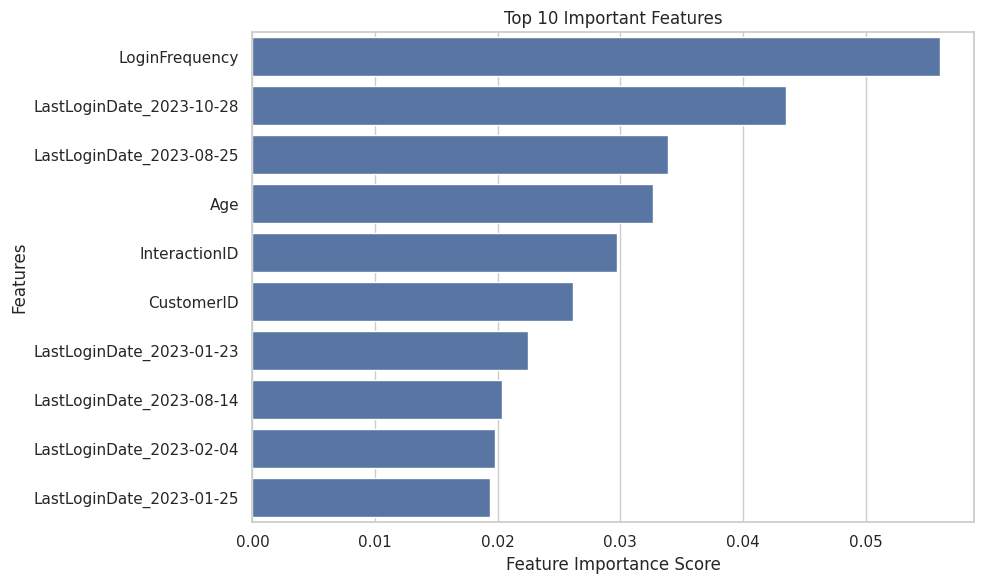

In [22]:

# Separate target and features
X = df.drop("ChurnStatus", axis=1)
y = df["ChurnStatus"]

# Handle categorical variables if not already encoded
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Feature Importance
importances = best_model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
